In [1]:
import os
import pandas as pd
import glob
import re
import dxchange
from tqdm import tqdm

from ipywidgets import interactive
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


# define location of files

In [2]:
# define where the ascii files are located
root_folder = "/HFIR/CG1D/IPTS-34718/shared/processed_data/jean/"
assert os.path.exists(root_folder)

data_set_folder = "/HFIR/CG1D/IPTS-34718/shared/processed_data/normalized/2025_02_19_1MCsOH_60C_60s"
assert os.path.exists(data_set_folder)


In [3]:
# list of working images
list_of_images = glob.glob(os.path.join(data_set_folder, "*.tiff"))
list_of_images.sort()


# Mean region vs file (file produced by the notebook create-list-of-file-names-vs-time-stamp.ipynb)

In [4]:
# Mean region vs file (file produced by the notebook create-list-of-file-names-vs-time-stamp.ipynb)
def get_timestamp_vs_file(file_name):
    """
    Read the mean region vs file ascii file and return a pandas dataframe
    """
    # read the ascii file
    df = pd.read_csv(file_name, sep=",", skiprows=1, header=None)
    # # remove the first column
    # df = df.iloc[:, 1:]
    # rename the columns
    df.columns = ["file name", "time (unix)", "time (user format)", "timeoffset (s)"]
    return df

ascii_file = os.path.join(root_folder, "2025_02_19_1MCsOH_60C_60s_timestamp_infos.txt")
assert os.path.exists(ascii_file)

data_timestamp = get_timestamp_vs_file(ascii_file)

# get mean counts vs file index

In [5]:
mean_counts_ascii_file = os.path.join(root_folder, "Values.csv")
assert os.path.exists(mean_counts_ascii_file)

In [6]:
def get_mean_counts_vs_file(file_name):
    """
    Read the mean counts vs file ascii file and return a pandas dataframe
    """
    # read the ascii file
    df = pd.read_csv(file_name, sep=",", skiprows=1, header=None)
    # remove first column
    df = df.iloc[:,1:]
    # rename the columns
    df.columns = ["mean counts"]
    return df
data_mean_counts = get_mean_counts_vs_file(mean_counts_ascii_file)


# merge the two dataframes

In [7]:
data = pd.merge(data_timestamp, data_mean_counts, left_index=True, right_index=True)

In [8]:
data_time_offset = data["timeoffset (s)"].values
data_mean_counts = data["mean counts"].values

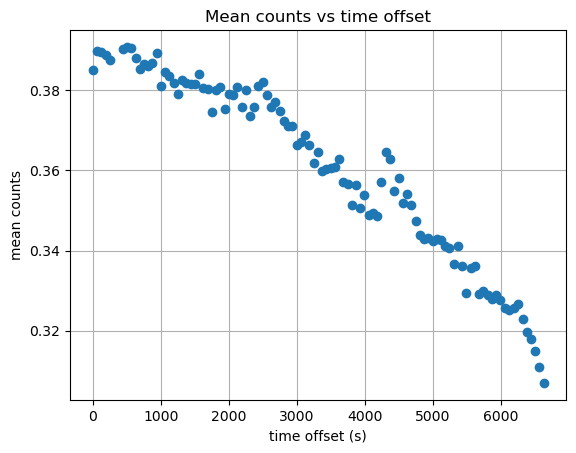

In [9]:
plt.figure(0)
plt.plot(data_time_offset, data_mean_counts, "o")
plt.xlabel("time offset (s)")
plt.ylabel("mean counts")
plt.title("Mean counts vs time offset")
plt.grid()


# take mean of files with same intensity (but only use the last 10 of each - when stabilization has been reached)

In [13]:
list_file_names = list(data['file name'])
parent_folder = os.path.basename(os.path.dirname(list_file_names[0]))
list_base_file_names = [os.path.basename(_file) for _file in list_file_names]

# list of intensities
search_string = f"^(?P<intensity>\d*mA)\_\d*_\d*.tiff"
dict_intensities = {}
for _index, _file in enumerate(list_base_file_names):
    m = re.match(search_string, _file)
    if m:
        dict_intensities[m['intensity']] = dict_intensities.get(m['intensity'], [])
        dict_intensities[m['intensity']].append(data['mean counts'][_index])

# for each key, keep only the last 10 files (indexes)
for _key in dict_intensities.keys():
    dict_intensities[_key] = dict_intensities[_key][-10:]

In [15]:
dict_intensities

mean_counts_last_10 = []
x_axis = []
for _key in dict_intensities.keys():
    _mean = np.mean(dict_intensities[_key])
    mean_counts_last_10.append(_mean)
    x_axis.append(_key)

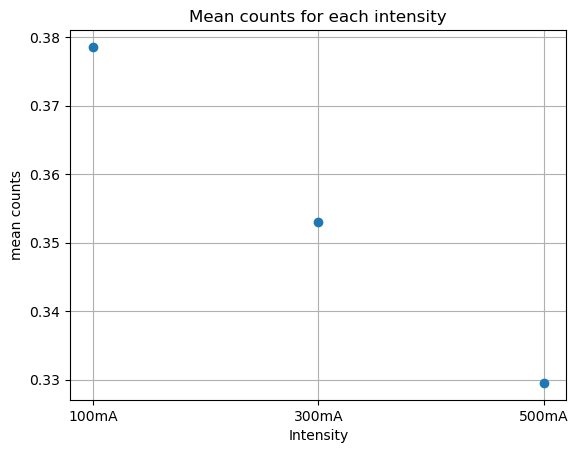

In [21]:
plt.figure(1)
plt.plot(mean_counts_last_10, "o")
plt.xlabel("Intensity")
plt.ylabel("mean counts")
plt.title("Mean counts for each intensity")
plt.xticks(ticks=[0,1,2], labels=x_axis)

plt.grid()